# Importing Modules
##### Import the following modules
- dowhy
- numpy as np
- pandas as pd
- pydot
- causallearn
- matplotlib.pyplot as plt
- networkx as nx

In [9]:
import numpy as np
import pandas as pd
import dowhy
import pydot
import causallearn
import matplotlib.pyplot as plt
import networkx as nx

# Read Dataset and Discover Graphical Causal Model(GCM)
#### To discover the GCM
- Use a causal discovery algorithm called PC algorithm
- In this algorithm the conditional independance test(CIT) use by me is KCI (Kernel-based Conditional Independence Test
- We can change the CIT to others like gsq,chisq,fisherz,mv-fisherz to see which test gets us better results
- We will graph the result obtained from this test using pydot

Depth=4, working on node 8: 100%|██████████| 9/9 [00:04<00:00,  2.12it/s]  


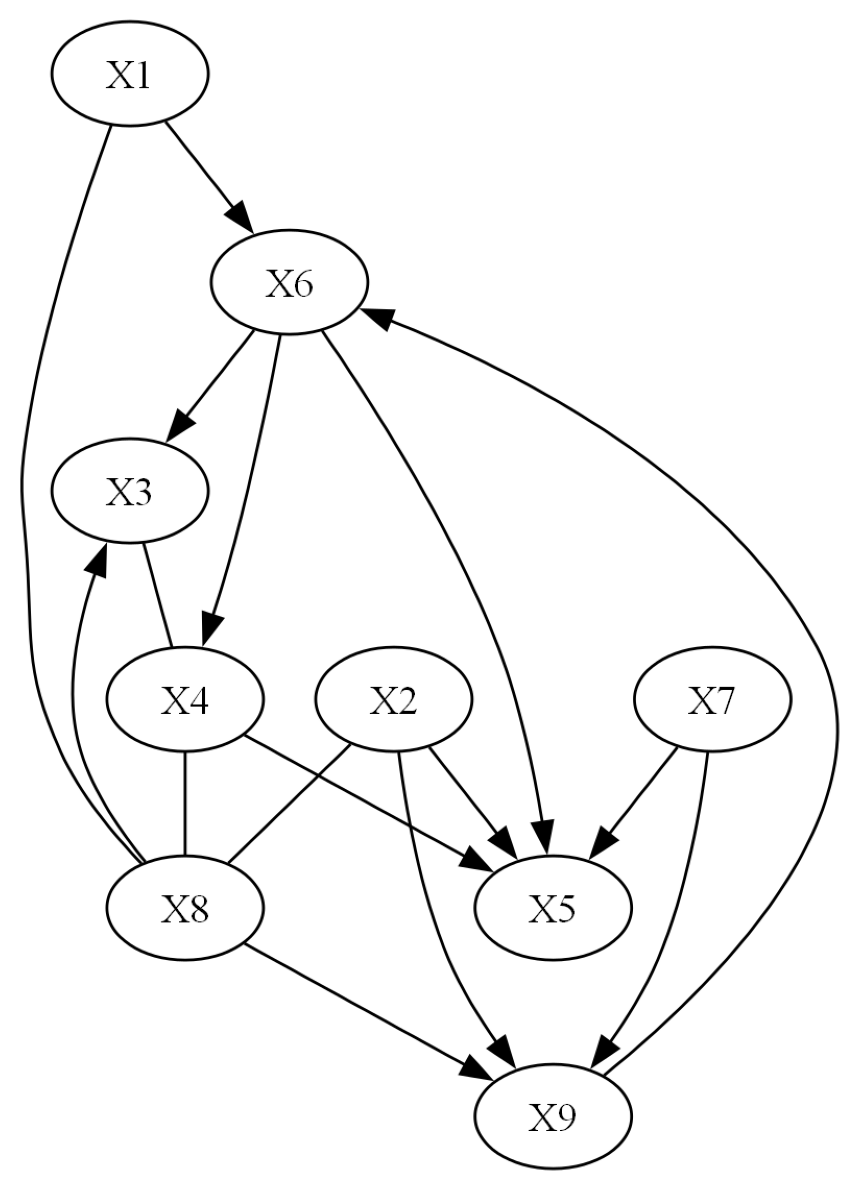

In [15]:
from causallearn.search.ConstraintBased.PC import pc
from causallearn.utils.cit import kci,chisq,gsq,fisherz,mv_fisherz
from causallearn.graph.GraphNode import GraphNode
from causallearn.utils.PCUtils.BackgroundKnowledge import BackgroundKnowledge
df=pd.read_csv(r".\diabetes.csv")
data=df.values

nodes = [GraphNode(f"x{i+1}") for i in range(9)]


bk = BackgroundKnowledge()

for i in range(8):
    bk.add_forbidden_by_node(nodes[8], nodes[i])
    
G = pc(data,0.05,indep_test= kci,background_knowledge=bk)#kci takes a long time but it was the one whose results i found satisfactory
G.draw_pydot_graph()

- Clean up the connections with no arrows using your own knowledge and add some where you feel they should be according to your background knowledge
- note that x9 in our case is the output column and thus cannot be a source despite algorithm implying otherwise
- after this we will try to refute the graph using our dataset to prove the robustness of our dataset

In [10]:
dag="""
digraph{
    Pregnancies;
    Glucose;
    BloodPressure;
    SkinThickness;
    Insulin;
    BMI;
    DiabetesPedigreeFunction;
    Age;
    Outcome;
    Pregnancies -> BMI;
    Age -> Pregnancies;
    Glucose -> Insulin;
    Glucose -> Outcome;
    Age -> Glucose;
    Age -> BloodPressure;
    SkinThickness -> BloodPressure;
    BMI -> BloodPressure;
    Age -> SkinThickness;
    BMI -> SkinThickness;
    SkinThickness -> Insulin;
    BMI -> Insulin;
    DiabetesPedigreeFunction -> Insulin;
    DiabetesPedigreeFunction -> Outcome;
    Age -> Outcome;
    BloodPressure -> Outcome
    
}"""#modified according to what i believe is correct but i am not a medical professional

from dowhy.gcm.falsify import falsify_graph

pydot_graph = pydot.graph_from_dot_data(dag)[0]
pydot_graph = pydot.graph_from_dot_data(dag)[0]
nx_graph = nx.drawing.nx_pydot.from_pydot(pydot_graph)

result = falsify_graph(nx_graph, df, show_progress_bar=False)

print(f"Is Result False: {result.falsified}")

Is Result False: False


- above output implies the graph used is appropriate according to our dataset

In [ ]:
from dowhy.causal_model import CausalModel
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
df=pd.read_csv(r".\diabetes.csv")
df['BMI'] = (df['BMI'] > 25).astype(int)# checking how causal effect varies with BMI>25
model = CausalModel(
    data=df,
    treatment="BMI",  
    outcome="Outcome",
    graph=dag
)
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True, method_name="maximal-adjustment")
estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.linear_regression",
)

res_placebo=model.refute_estimate(identified_estimand, estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute")
print(res_placebo)

print("\n=== Causal Model Summary ===\n")

print("\nEstimated Causal Effect:")
print(f"  {estimate}\n")
print("Placebo Treatment Refutation Results:")
print(res_placebo) 


Refute: Use a Placebo Treatment
Estimated effect:0.2434772667761464
New effect:-0.0041871303868722285
p value:0.96


=== Causal Model Summary ===


Estimated Causal Effect:
  *** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                                                
──────(E[Outcome|Glucose,DiabetesPedigreeFunction,Pregnancies,Age])
d[BMI]                                                             
Estimand assumption 1, Unconfoundedness: If U→{BMI} and U→Outcome then P(Outcome|BMI,Glucose,DiabetesPedigreeFunction,Pregnancies,Age,U) = P(Outcome|BMI,Glucose,DiabetesPedigreeFunction,Pregnancies,Age)

## Realized estimand
b: Outcome~BMI+Glucose+DiabetesPedigreeFunction+Pregnancies+Age+BMI*Glucose+BMI*DiabetesPedigreeFunction
Target units: 

## Estimate
Mean value: 0.2434772667761464
### Conditional Estimates
__categorical__Glucose  __categorical__DiabetesPe

### Interpretation of the Causal Effect Output  

- When **BMI > 25**, the **mean causal effect** is **0.2434**, meaning that having a BMI greater than 25 is associated with a **24.35% increased chance of developing diabetes**.  

- To validate this estimate, we perform a **placebo test**, which involves **randomizing** the treatment variable (`BMI > 25`). If the estimated effect from randomized values remains similar, it would indicate that the treatment variable (BMI > 25) is not actually influencing the outcome.  

- A **robust estimate** should show a **very low new effect** after refutation, and the **p-value should be high**, indicating that the original estimate is unlikely due to random chance.  

- The output also includes a **table** that demonstrates how the impact of **BMI > 25** varies depending on factors like **Glucose level** and **Diabetes Pedigree Function**, highlighting the nuanced relationship between BMI and diabetes risk.

- Table can be interpreted as shown below

![HEATMAP](Output%20Heatmap.jpg)


- By varying Treatment and modifying the dataframe as needed we can find causal effect of a variety of different factors such as (`Age>50`),(`BloodPressure>100`) and so on
- It is however not necessary to modify the dataframe and we can use it as is in which case the output implies that for an increase of every 1 unit the chance of outcome increases by <effect> amount with max being 1
- Below is another example showcasing (`Age>50`)

In [19]:
from dowhy.causal_model import CausalModel
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
df=pd.read_csv(r".\diabetes.csv")
df['Age'] = (df['Age'] > 50).astype(int)# checking how causal effect varies with BMI>25
model = CausalModel(
    data=df,
    treatment="Age",  
    outcome="Outcome",
    graph=dag
)
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True, method_name="maximal-adjustment")
estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.linear_regression",
)

res_placebo=model.refute_estimate(identified_estimand, estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute")
print(res_placebo)

print("\n=== Causal Model Summary ===\n")

print("\nEstimated Causal Effect:")
print(f"  {estimate}\n")
print("Placebo Treatment Refutation Results:")
print(res_placebo) 

Refute: Use a Placebo Treatment
Estimated effect:0.12675541652176497
New effect:0.0006630438892951218
p value:0.98


=== Causal Model Summary ===


Estimated Causal Effect:
  *** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d               
──────(E[Outcome])
d[Age]            
Estimand assumption 1, Unconfoundedness: If U→{Age} and U→Outcome then P(Outcome|Age,,U) = P(Outcome|Age,)

## Realized estimand
b: Outcome~Age+Age*DiabetesPedigreeFunction
Target units: 

## Estimate
Mean value: 0.12675541652176497
### Conditional Estimates
__categorical__DiabetesPedigreeFunction
(0.077, 0.219]    0.047723
(0.219, 0.303]    0.072559
(0.303, 0.454]    0.101874
(0.454, 0.687]    0.151897
(0.687, 2.42]     0.260240
dtype: float64

Placebo Treatment Refutation Results:
Refute: Use a Placebo Treatment
Estimated effect:0.12675541652176497
New effect:0.0006630438892951218
p value:0.98



- We need not always get a tabular output.  

- The effect of being above 50 is described to be a **12% increase** in the chance of diabetes, and it is accurate as a placebo treatment proves it to be valid.  

- For the above execution, however, we do have a graphical output.  

![GRAPH](Output2%20Heatmap.png)  
